#Task 1

###Problem Statement

Report a plot of $\epsilon$ where
$$ \epsilon = min || |\psi(\theta)> - |\phi> ||$$
$\psi(\theta)$ is the output of the Paramtertised Quantum Circuit as displayed in the question.

The problem has been formulated as an unconstrained L2 loss system. We are attempting to solve this using an elementary Quantum approximate optimization algorithm method, sequentially using layers of unitary angle parametrised operators to solve this problem.

In [ ]:
!pip install qiskit
!pip install pylatexenc

In [2]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import qiskit as q

Defining necessary functions to make the circuit. Functions for the odd and even layers.


In [3]:
N_qub = 4

#Defining helper functions to create the circuits
def evenLayer(circ, layer_num, theta):
  for i in range(N_qub):
    circ.rz(theta[layer_num,i],i)

  #Full entanglement
  for i in range(N_qub):
    for j in range(i+1,N_qub):
      circ.cz(i,j)

def oddLayer(circ, layer_num, theta):
  for i in range(N_qub):
    circ.rx(theta[layer_num,i],i)

def createCirc(theta):
  theta2 = theta.reshape((2*N_layer, N_qub))
  qr = q.QuantumRegister(4, name="q")
  cr = q.ClassicalRegister(4, name='c')
  circ = q.QuantumCircuit(qr, cr)
  ##Adding layers
  for i in range(N_layer):
    oddLayer(circ, 2*(i-1),theta2)
    evenLayer(circ, 2*i-1,theta2)
  return circ

The statevector simulator was used as we need to optimize with respect to a state.

NOTE: 1 layer = 1 odd + 1 even layer.

(8,) 8
Output Error: 1.0136288570343814
(16,) 16
Output Error: 0.674090260227924
(24,) 24
Output Error: 0.33824904625838687
(32,) 32
Output Error: 0.266714746116753
(40,) 40
Output Error: 0.06862939436440559
(48,) 48
Output Error: 0.08962209892769527
(56,) 56
Output Error: 0.08893027354264584
(64,) 64
Output Error: 0.03509179532536876
(72,) 72
Output Error: 0.039643415034283626


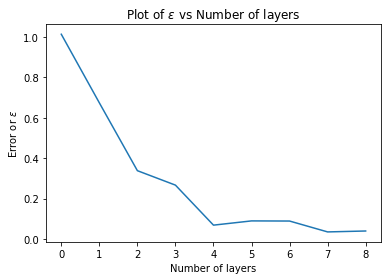

In [10]:
N_qub = 4
target_vec = np.asarray(q.quantum_info.random_statevector(16, seed = 10)._data)
backend = q.Aer.get_backend("statevector_simulator")

N_layer = 1 ##GLOBALLY USED in createCirc function
N_layer_max = 10
max_iter = 1500
#Variable to store error in all the layers, to check convergence
error = []

#Defining the objective function
def objective_function(theta):
    qc = createCirc(theta) #The global N_layer value is used
    result = q.execute(qc, backend).result()
   
    cost = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5
    error.append(cost)
    return cost

from qiskit.aqua.components.optimizers import COBYLA

#Array for storing minimum error of each layer
cost_arr = np.zeros((N_layer_max-1,))

#defining optimizer
optimizer = COBYLA(maxiter=max_iter)

#Running the simulation
while N_layer<N_layer_max:
  #Parameter
  theta = np.random.uniform(0,2*np.pi, (2*N_layer*N_qub))
  print(theta.shape, (2*N_layer*N_qub))
  ret = optimizer.optimize(num_vars=(2*N_layer*N_qub), objective_function=objective_function, initial_point=theta, variable_bounds = [(0,2*np.pi) for i in range(2*N_layer*N_qub)])

  #Getting final result
  qc = createCirc(ret[0])
  result = q.execute(qc, backend).result()
  cost_arr[N_layer-1] = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5

  print("Output Error:", ret[1])
  #print("Parameters Found:", ret[0])
  N_layer = N_layer+1
#Plot
plt.title("Plot of $\epsilon$ vs Number of layers")
plt.ylabel("Error or $\epsilon$")
plt.xlabel("Number of layers")
plt.plot(cost_arr)

The observation as expected is that as expected, with more layers, our search space increases, and we converge to lower errors.

With an increasing number of parameters, more number of iterations are needed for convergence. This has been described in graphs shown below.


 

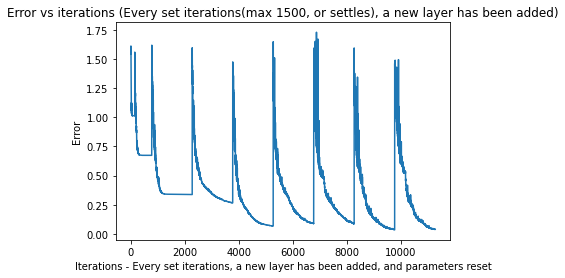

In [12]:
plt.title("Error vs iterations (Every set iterations(max 1500, or settles), a new layer has been added)")
plt.xlabel("Iterations - Every set iterations, a new layer has been added, and parameters reset")
plt.ylabel("Error")
plt.plot(error)

The error visibly decreases with addition of every layer, correctly corrobarating with expectations.

To describe the plot above, the first few iterations(1500 iters) are for a circuit with only 1 layer. The second of iterations(Once the error peaks again to when it settles) are for a circuit with 2 layers, and this is the same till 9 layers.

This plot is to measure how well the error for each of the circuits settles. As expected, more the number of parameters, we see it takes longer to settle. FOr simplicity, i have fixed all iterations to 1500, however, this is not sufficient for higher number of layers.

###Bonus question
Answering the **bonus question** on the range of theta we need to consider, presented as a comment on the google doc.

If we look at the Rz gate,
$$
R_z(\theta) = \begin{bmatrix}
e^{j\theta/2} & 0 \\
0 & e^{-j\theta/2} 
\end{bmatrix}
$$

This can be rewritten as 
$$
R_z(\theta) = e^{j\theta/2}\begin{bmatrix}
1 & 0 \\
0 & e^{-j\theta}
\end{bmatrix}
$$

This is just an overall phase of just $\theta/2$, and can be neglected, and hence, just sampling $\theta$ from (0,2$\pi$) is sufficient, instead of (0,$4\pi$).

###Bonus task
Answering the main **bonus task**, I am running the simulation for another parametrised gate to compare performance.

Here, I am relpacing the Rx gate with an Ry gate, and making Ry part of the even layer, Rz part of the odd layer

In [7]:
N_qub = 4

#Defining helper functions to create the circuits
def evenLayer(circ, layer_num, theta):
  for i in range(N_qub):
    circ.ry(theta[layer_num,i],i)

  #Full entanglement
  for i in range(N_qub):
    for j in range(i+1,N_qub):
      circ.cz(i,j)

def oddLayer(circ, layer_num, theta):
  for i in range(N_qub):
    circ.rz(theta[layer_num,i],i)

def createCirc(theta):
  theta2 = theta.reshape((2*N_layer, N_qub))
  qr = q.QuantumRegister(4, name="q")
  cr = q.ClassicalRegister(4, name='c')
  circ = q.QuantumCircuit(qr, cr)
  ##Adding layers
  for i in range(N_layer):
    oddLayer(circ, 2*(i-1),theta2)
    evenLayer(circ, 2*i-1,theta2)
  return circ

(8,) 8
Output Error: 1.0136288572689693
(16,) 16
Output Error: 0.7171766787607246
(24,) 24
Output Error: 0.4054438103696956
(32,) 32
Output Error: 0.1974138048920423
(40,) 40
Output Error: 0.09617985802189227
(48,) 48
Output Error: 0.14086885169191074
(56,) 56
Output Error: 0.10060868213324987
(64,) 64
Output Error: 0.12644628709087077
(72,) 72
Output Error: 0.05469878388055493


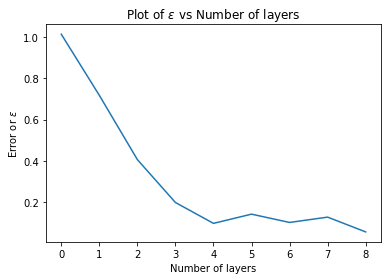

In [8]:
N_qub = 4
target_vec = np.asarray(q.quantum_info.random_statevector(16, seed = 10)._data)
backend = q.Aer.get_backend("statevector_simulator")

N_layer = 1 ##GLOBALLY USED in createCirc function
N_layer_max = 10
max_iter = 1500
#Variable to store error in all the layers, to check convergence
error = []

#Defining the objective function
def objective_function(theta):
    qc = createCirc(theta) #The global N_layer value is used
    result = q.execute(qc, backend).result()

    cost = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5
    error.append(cost)
    return cost

from qiskit.aqua.components.optimizers import COBYLA

#Array for storing minimum error of each layer
cost_arr = np.zeros((N_layer_max-1,))
optimizer = COBYLA(maxiter=max_iter)

#Running the simulation
while N_layer<N_layer_max:
  #Parameter
  theta = np.random.uniform(0,2*np.pi, (2*N_layer*N_qub))
  print(theta.shape, (2*N_layer*N_qub))
  ret = optimizer.optimize(num_vars=(2*N_layer*N_qub), objective_function=objective_function, initial_point=theta, variable_bounds = [(0,2*np.pi) for i in range(2*N_layer*N_qub)])

  #Getting final result
  qc = createCirc(ret[0])
  result = q.execute(qc, backend).result()
  cost_arr[N_layer-1] = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5

  print("Output Error:", ret[1])
  #print("Parameters Found:", ret[0])
  N_layer = N_layer+1
#Plot
plt.title("Plot of $\epsilon$ vs Number of layers")
plt.ylabel("Error or $\epsilon$")
plt.xlabel("Number of layers")
plt.plot(cost_arr)

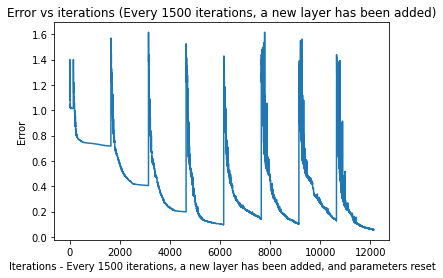

In [9]:
plt.title("Error vs iterations (Every 1500 iterations, a new layer has been added)")
plt.xlabel("Iterations - Every 1500 iterations, a new layer has been added, and parameters reset")
plt.ylabel("Error")
plt.plot(error)

Performance here is pretty similar. Different permutations of these parametrised gates were tried.

In essence, 2 rotations are needed to rotate from one point on the bloch sphere to another, so these permutations are performing similarly.